<a href="https://colab.research.google.com/github/fabriciocarraro/NLP-exploration_Sentiment-analysis-Disaster_prediction/blob/main/NLP_exploration_Sentiment_analysis_Disaster_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Uninstall any existing PyTorch packages
!pip uninstall -y -q torch torchaudio torchvision

In [3]:
!pip install -q torch==2.0.1+cu118 torchvision==0.15.2+cu118 torchtext==0.15.2 -f https://download.pytorch.org/whl/torch_stable.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 488.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 8.0 MB/s eta 0:00:00


In [4]:
!pip install -q "numpy<2"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 45.6 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from xgboost import XGBClassifier
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, GloVe
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from typing import Tuple
import time

In [2]:
SEED = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [4]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [5]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train_df.isnull().sum()

,0
id,0
keyword,61
location,2533
text,0
target,0


In [7]:
train_df = train_df[['text', 'target']]
train_df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
print(train_df['target'].value_counts())

target
0    4342
1    3271
Name: count, dtype: int64


# Bag-of-Words with Logistic Regression

In [9]:
def bow(model, dataset, reviews_column, classification_column):
  vectorizer = CountVectorizer(max_features=50)
  bag_of_words = vectorizer.fit_transform(dataset[reviews_column])


  X_train, X_test, y_train, y_test = train_test_split(bag_of_words,
                                                      dataset[classification_column],
                                                      random_state=SEED,
                                                      stratify=dataset[classification_column])


  model.fit(X_train, y_train)
  predictions = model.predict(X_test)

  accuracy = accuracy_score(y_test, predictions)
  print(f'- Accuracy: {accuracy*100:.2f}%')
  precision = precision_score(y_test, predictions)
  print(f'- Precision: {precision*100:.2f}%')
  recall = recall_score(y_test, predictions)
  print(f'- Recall: {recall*100:.2f}%')
  f1 = f1_score(y_test, predictions)
  print(f'- F1-Score: {f1*100:.2f}%')
  roc_auc = roc_auc_score(y_test, predictions)
  print(f'- ROC-AUC: {roc_auc*100:.2f}%')

  return [accuracy, precision, recall, f1, roc_auc]

In [10]:
# BOW - Logistic Regression - Untreated text
model_log_reg = LogisticRegression()
print("BOW - Logistic Regression - Untreated text\n")
bow_lg_untreated = bow(model_log_reg, train_df, 'text', 'target')

BOW - Logistic Regression - Untreated text

- Accuracy: 68.22%
- Precision: 65.68%
- Recall: 54.52%
- F1-Score: 59.59%
- ROC-AUC: 66.53%


In [11]:
# Cleaning up the text data
import spacy

spacy.prefer_gpu()
print("Using GPU:", spacy.prefer_gpu())

nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    text = text.lower()

    doc = nlp(text)

    cleaned_tokens = [
        token.lemma_ for token in doc
        if not token.is_punct            # Remove punctuation
        and not token.is_space           # Remove whitespaces
        and not token.is_stop            # Remove stop words
        and not token.like_url           # Remove URLs
        and not token.like_email         # Remove emails
        and token.is_alpha               # Remove non-alphabetic tokens
        and len(token.text) > 2          # Remove short words
    ]

    cleaned_text = " ".join(cleaned_tokens)
    return cleaned_text

Using GPU: True


In [12]:
treated_phrases = list()
for review in train_df['text']:
    new_phrase = preprocess_text(review)
    treated_phrases.append(new_phrase)

train_df.loc[:, 'treated_text'] = treated_phrases
train_df

,text,target,treated_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,Just got sent this photo from Ruby #Alaska as ...,1,get send photo ruby alaska smoke wildfire pour...
...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,1,giant crane hold bridge collapse nearby home
7609,@aria_ahrary @TheTawniest The out of control w...,1,control wild fire california northern state tr...
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,volcano hawaii
7611,Police investigating after an e-bike collided ...,1,police investigate bike collide car little por...


In [13]:
# Add length column for the treated text
train_df['treated_text_length'] = train_df['treated_text'].fillna('').apply(len)
print(train_df['treated_text_length'].min())

0


In [14]:
train_df

,text,target,treated_text,treated_text_length
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,36
1,Forest fire near La Ronge Sask. Canada,1,forest fire near ronge sask canada,34
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,79
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...,51
4,Just got sent this photo from Ruby #Alaska as ...,1,get send photo ruby alaska smoke wildfire pour...,53
...,...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,1,giant crane hold bridge collapse nearby home,44
7609,@aria_ahrary @TheTawniest The out of control w...,1,control wild fire california northern state tr...,53
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,volcano hawaii,14
7611,Police investigating after an e-bike collided ...,1,police investigate bike collide car little por...,94


In [15]:
# Remove empty reviews after the treatment and show the length (in words) of the shortest review
train_df_cleaned = train_df[train_df['treated_text_length'] > 0].reset_index(drop=True)
print(train_df_cleaned['treated_text_length'].min())

3


In [16]:
# BOW - Logistic Regression - Treated text
model_log_reg = LogisticRegression()
print("BOW - Logistic Regression - Treated text\n")
bow_lg_treated = bow(model_log_reg, train_df_cleaned, 'treated_text', 'target')

BOW - Logistic Regression - Treated text

- Accuracy: 69.45%
- Precision: 72.35%
- Recall: 46.76%
- F1-Score: 56.80%
- ROC-AUC: 66.65%


# Bag-of-Words with XGBoost

In [17]:
# BOW - XGBoost - Treated text
model_xgboost = XGBClassifier()
print("BOW - XGBoost - Treated text\n")
bow_xgboost_treated = bow(model_xgboost, train_df_cleaned, 'treated_text', 'target')

BOW - XGBoost - Treated text

- Accuracy: 70.19%
- Precision: 72.56%
- Recall: 49.20%
- F1-Score: 58.64%
- ROC-AUC: 67.60%


# TF-IDF with Logistic Regression

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(model, dataset, reviews_column, classification_column):
    tfidf = TfidfVectorizer(max_features=50)
    tfidf_data = tfidf.fit_transform(dataset[reviews_column])

    X_train, X_test, y_train, y_test = train_test_split(tfidf_data,
                                                        dataset[classification_column],
                                                        random_state=SEED,
                                                        stratify=dataset[classification_column])

    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    accuracy = accuracy_score(y_test, predictions)
    print(f'- Accuracy: {accuracy*100:.2f}%')
    precision = precision_score(y_test, predictions)
    print(f'- Precision: {precision*100:.2f}%')
    recall = recall_score(y_test, predictions)
    print(f'- Recall: {recall*100:.2f}%')
    f1 = f1_score(y_test, predictions)
    print(f'- F1-Score: {f1*100:.2f}%')
    roc_auc = roc_auc_score(y_test, predictions)
    print(f'- ROC-AUC: {roc_auc*100:.2f}%')

    return [accuracy, precision, recall, f1, roc_auc]

In [19]:
model_log_reg = LogisticRegression()
print("TF-IDF - Logistic Regression - Untreated text\n")
tdidf_lg_untreated = tfidf(model_log_reg, train_df_cleaned, 'text', 'target')
print("\nTF-IDF - Logistic Regression - Treated text\n")
tdidf_lg_treated = tfidf(model_log_reg, train_df_cleaned, 'treated_text', 'target')

TF-IDF - Logistic Regression - Untreated text

- Accuracy: 67.67%
- Precision: 64.11%
- Recall: 56.18%
- F1-Score: 59.88%
- ROC-AUC: 66.25%

TF-IDF - Logistic Regression - Treated text

- Accuracy: 69.03%
- Precision: 70.43%
- Recall: 48.10%
- F1-Score: 57.16%
- ROC-AUC: 66.45%


# TF-IDF with XGBoost

In [20]:
model_xgboost = XGBClassifier()
print("TF-IDF - XGBoost - Treated text\n")
tfidf_xgboost_treated = tfidf(model_xgboost, train_df_cleaned, 'treated_text', 'target')

TF-IDF - XGBoost - Treated text

- Accuracy: 68.66%
- Precision: 72.78%
- Recall: 43.21%
- F1-Score: 54.22%
- ROC-AUC: 65.52%


In [21]:
metrics_data = {
    'BOW - LR - Untreated': bow_lg_untreated,
    'BOW - LR - Treated': bow_lg_treated,
    'BOW - XGBoost - Treated': bow_xgboost_treated,
    'TF-IDF - LR - Untreated': tdidf_lg_untreated,
    'TF-IDF - LR - Treated': tdidf_lg_treated,
    'TF-IDF - XGBoost - Treated': tfidf_xgboost_treated
}

metrics_titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
df_metrics = pd.DataFrame(metrics_data, index=metrics_titles)

In [22]:
df_metrics

,BOW - LR - Untreated,BOW - LR - Treated,BOW - XGBoost - Treated,TF-IDF - LR - Untreated,TF-IDF - LR - Treated,TF-IDF - XGBoost - Treated
Accuracy,0.682248,0.694532,0.701893,0.676656,0.690326,0.686646
Precision,0.656848,0.723485,0.725632,0.641061,0.704301,0.727835
Recall,0.545232,0.467564,0.492044,0.561812,0.481028,0.432069
F1-Score,0.595858,0.568030,0.586433,0.598826,0.571636,0.542243
ROC-AUC,0.665342,0.666501,0.675976,0.662473,0.664477,0.655205


# RNNs (GRU & LSTM) with GloVe

From now on, I only use the treated data

In [23]:
treated_train_df = train_df_cleaned[['target', 'treated_text']]
treated_train_df

,target,treated_text
0,1,deed reason earthquake allah forgive
1,1,forest fire near ronge sask canada
2,1,resident ask shelter place notify officer evac...
3,1,people receive wildfire evacuation order calif...
4,1,get send photo ruby alaska smoke wildfire pour...
...,...,...
7600,1,giant crane hold bridge collapse nearby home
7601,1,control wild fire california northern state tr...
7602,1,volcano hawaii
7603,1,police investigate bike collide car little por...


In [24]:
len(treated_train_df['treated_text'])

7605

In [25]:
spacy.prefer_gpu()
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

In [26]:
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

MAX_VOCAB_SIZE = 25_000

vocab = build_vocab_from_iterator(
    yield_tokens(treated_train_df['treated_text']),
    max_tokens=MAX_VOCAB_SIZE,
    specials=['<unk>', '<pad>']
)

vocab.set_default_index(vocab['<unk>'])

**yield_tokens()** inside **build_vocab_from_iterator()**:

The common pattern of using a generator (with yield) is the Pythonic way and best approach to handle large datasets where you don't want to store all tokenized data in memory at once, but one could just as well pass a list of already-tokenized texts in one go (like a list of lists).

In [27]:
def collate_batch(batch):
    label_list, text_list, lengths = [], [], []

    for (_label, _text) in batch:
        label_list.append(_label)
        processed_text = torch.tensor(vocab(tokenizer(_text)), dtype=torch.int64)
        text_list.append(processed_text)
        lengths.append(len(processed_text))

    return (torch.tensor(label_list, dtype=torch.int64).to(device),
            nn.utils.rnn.pad_sequence(text_list, batch_first=True).to(device),
            torch.tensor(lengths, dtype=torch.int64).to(device))

**nn.utils.rnn.pad_sequence()**

When dealing with sequences of varying lengths, you need to ensure that all sequences in a given batch have a uniform shape before passing them into an RNN or other sequential models. Each text example can have a different number of tokens (e.g., one sentence could be 5 tokens, another 12 tokens). PyTorch's RNN modules need all sequences in a batch to be of the same length when you feed them in a single tensor.
"pad_sequence" automatically pads shorter sequences in the batch so they match the length of the longest sequence.

Also, **pad_sequence()** already returns a PyTorch tensor.

-----

**length**

In the RNN training pipeline, the model needs to know where the actual tokens end and where padding begins. By passing in the lengths of each sequence, PyTorch's RNN can skip padding positions and focus only on valid (non-padded) tokens. This avoids wasting computation on padding tokens, speeds up training, and can improve gradient flow for variable-length sequences.


In [28]:
BATCH_SIZE = 64

X_train, X_test, y_train, y_test = train_test_split(treated_train_df['treated_text'],
                                                    treated_train_df['target'],
                                                    random_state=SEED,
                                                    stratify=treated_train_df['target'])

train_dataset = [(y, x) for x, y in zip(X_train, y_train)]
test_dataset = [(y, x) for x, y in zip(X_test, y_test)]

train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              collate_fn=collate_batch)

test_dataloader = DataLoader(test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             collate_fn=collate_batch)

When one passes **collate_fn** to DataLoader, it applies this function (in our case, "collate_batch()") to every batch, handling the padding, creating tensors, and moving them to the right device (GPU). Without it, the default collation would likely fail or not handle padding for variable-length sequences correctly.

In [29]:
vectors = GloVe(name='6B', dim=100)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.41MB/s]                           
100%|█████████▉| 399999/400000 [00:18<00:00, 21061.74it/s]


In [30]:
class RNN_GRU(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, pad_idx):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
    self.rnn = nn.GRU(embedding_dim, hidden_size, num_layers=2, dropout=0.2, batch_first=True, bidirectional=True)
    self.fc = nn.Linear(hidden_size * 2, output_size)

    self.embedding.weight.data.copy_(vectors.get_vecs_by_tokens(vocab.get_itos()))
    self.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

  def forward(self, text, lengths):
    embedded = self.embedding(text)
    packed_embedded = pack_padded_sequence(embedded,
                                           lengths.cpu(),
                                           batch_first=True,
                                           enforce_sorted=False)

    packed_output, _ = self.rnn(packed_embedded)
    output, _ = pad_packed_sequence(packed_output, batch_first=True)
    output = F.adaptive_max_pool1d(output.transpose(1, 2), 1).squeeze(dim=-1)
    return self.fc(output)

When you feed integer IDs (coming from your vocabulary) into **nn.Embedding**, it returns a corresponding dense vector of size **embedding_dim**. For example, if embedding_dim=100, then each token index turns into a 100-dimensional vector.

The embedding layer maintains a matrix of shape (vocab_size, embedding_dim). Each row corresponds to a specific token's embedding vector, and these vectors get updated during training via backpropagation to capture semantic or syntactic relationships among tokens.

---

**pack_padded_sequence** is converts a batch of padded sequences into a packed representation. Packed sequences let PyTorch's RNN modules skip the padded tokens during processing and focus only on the valid (non-padded) parts of each sequence. The output of **pack_padded_sequence()** is a special "PackedSequence" object that is then fed to the RNN.



In [31]:
class RNN_GRU_withAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.GRU(embedding_dim, hidden_size, num_layers=2, dropout=0.2, batch_first=True, bidirectional=True)
        # Attention mechanism - a simple feedforward layer that outputs an "energy" score
        # for each time step. Then we'll take a softmax to get the attention weights.
        self.attn = nn.Linear(hidden_size * 2, 1)  # because bidirectional => hidden_size*2
        self.fc = nn.Linear(hidden_size * 2, output_size)

        self.embedding.weight.data.copy_(vectors.get_vecs_by_tokens(vocab.get_itos()))
        self.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

    def forward(self, text, lengths):
        embedded = self.embedding(text)
        packed_embedded = pack_padded_sequence(embedded,
                                            lengths.cpu(),
                                            batch_first=True,
                                            enforce_sorted=False)

        packed_output, _ = self.rnn(packed_embedded)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        # Attention scores - transform each hidden state to a single "energy" value
        attn_energies = self.attn(output)
        # Convert energies to attention weights via softmax along time dimension
        attn_weights = F.softmax(attn_energies.squeeze(-1), dim=1)

        # Weighted sum of hidden states to get a single context vector
        context = torch.bmm(
            attn_weights.unsqueeze(1),  # (batch_size, 1, seq_len)
            output                      # (batch_size, seq_len, hidden_size*2)
        ).squeeze(1)                     # => (batch_size, hidden_size*2)

        return self.fc(context)

In [32]:
class RNN_LSTM(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, pad_idx):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
    self.rnn = nn.LSTM(embedding_dim, hidden_size, num_layers=2, dropout=0.2, batch_first=True, bidirectional=True)
    self.fc = nn.Linear(hidden_size * 2, output_size)

    self.embedding.weight.data.copy_(vectors.get_vecs_by_tokens(vocab.get_itos()))
    self.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

  def forward(self, text, lengths):
    embedded = self.embedding(text)
    packed_embedded = pack_padded_sequence(embedded,
                                           lengths.cpu(),
                                           batch_first=True,
                                           enforce_sorted=False)

    packed_output, _ = self.rnn(packed_embedded)
    output, _ = pad_packed_sequence(packed_output, batch_first=True)
    output = F.adaptive_max_pool1d(output.transpose(1, 2), 1).squeeze(dim=-1)
    return self.fc(output)

In [33]:
class RNN_LSTM_withAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.LSTM(embedding_dim, hidden_size, num_layers=2, dropout=0.2, batch_first=True, bidirectional=True)
        # Attention mechanism - a simple feedforward layer that outputs an "energy" score
        # for each time step. Then we'll take a softmax to get the attention weights.
        self.attn = nn.Linear(hidden_size * 2, 1)  # because bidirectional => hidden_size*2
        self.fc = nn.Linear(hidden_size * 2, output_size)

        self.embedding.weight.data.copy_(vectors.get_vecs_by_tokens(vocab.get_itos()))
        self.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

    def forward(self, text, lengths):
        embedded = self.embedding(text)
        packed_embedded = pack_padded_sequence(embedded,
                                            lengths.cpu(),
                                            batch_first=True,
                                            enforce_sorted=False)

        packed_output, _ = self.rnn(packed_embedded)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        # Attention scores - transform each hidden state to a single "energy" value
        attn_energies = self.attn(output)
        # Convert energies to attention weights via softmax along time dimension
        attn_weights = F.softmax(attn_energies.squeeze(-1), dim=1)

        # Weighted sum of hidden states to get a single context vector
        context = torch.bmm(
            attn_weights.unsqueeze(1),  # (batch_size, 1, seq_len)
            output                      # (batch_size, seq_len, hidden_size*2)
        ).squeeze(1)                     # => (batch_size, hidden_size*2)

        return self.fc(context)

In [34]:
def train_epoch(model, dataloader, model_optimizer, criterion):
    model.train()
    total_loss = batch_count = 0
    all_predictions = []
    all_labels = []
    all_probs = []  # Probabilities of the 1 class (for the ROC curve)
    start = time.time()

    for labels, text, lengths in dataloader:
        model_optimizer.zero_grad()
        predictions = model(text, lengths)
        loss = criterion(predictions, labels)

        loss.backward()
        model_optimizer.step()

        pred_labels = predictions.argmax(dim=1)
        total_loss += loss.item()
        batch_count += 1

        # Storing predictions and labels to calculate the F1-score and the ROC curve
        all_predictions.extend(pred_labels.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Probabilities of the 1 class (for the ROC curve)
        probs = torch.nn.functional.softmax(predictions, dim=1)[:, 1].detach().cpu().numpy()
        all_probs.extend(probs)

    train_loss = total_loss / batch_count

    f1 = f1_score(all_labels, all_predictions)

    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    end = time.time()

    print(f"Train Loss: {train_loss:.4f} | F1 Score: {f1:.4f} | AUC-ROC: {roc_auc:.4f} | Time: {end-start:.2f}s")

    return train_loss, f1, {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc, 'thresholds': thresholds}


def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = batch_count = 0
    all_predictions = []
    all_labels = []
    all_probs = []  # Probabilities of the 1 class (for the ROC curve)
    start = time.time()

    with torch.no_grad():
        for labels, text, lengths in dataloader:
            predictions = model(text, lengths)
            loss = criterion(predictions, labels)

            pred_labels = predictions.argmax(dim=1)
            total_loss += loss.item()
            batch_count += 1

            # Storing predictions and labels to calculate the F1-score and the ROC curve
            all_predictions.extend(pred_labels.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Probabilities of the 1 class (for the ROC curve)
            probs = torch.nn.functional.softmax(predictions, dim=1)[:, 1].detach().cpu().numpy()
            all_probs.extend(probs)

    valid_loss = total_loss / batch_count

    f1 = f1_score(all_labels, all_predictions)

    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    end = time.time()
    print(f"Valid Loss: {valid_loss:.4f} | F1 Score: {f1:.4f} | AUC-ROC: {roc_auc:.4f} | Time: {end-start:.2f}s")

    return valid_loss, f1, {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc, 'thresholds': thresholds}

In [35]:
def run_model(model, model_optimizer, nn_type):
    N_EPOCHS = 30
    best_val_f1 = 0.0

    train_losses, valid_losses = [], []
    train_f1s, valid_f1s = [], []
    train_aucs, valid_aucs = [], []
    best_roc_data = None

    for epoch in range(N_EPOCHS):
        print(f"Epoch: {epoch+1:02d}")

        train_loss, train_f1, train_roc_data = train_epoch(model, train_dataloader, model_optimizer, criterion)
        valid_loss, valid_f1, valid_roc_data = evaluate(model, test_dataloader, criterion)

        # Comparing valid_f1 with best_val_f1
        if valid_f1 > best_val_f1:
            best_val_f1 = valid_f1
            best_roc_data = valid_roc_data
            # Save the model's state_dict
            torch.save(model.state_dict(), f"best_model_{nn_type}.pt")

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_f1s.append(train_f1)
        valid_f1s.append(valid_f1)
        train_aucs.append(train_roc_data['roc_auc'])
        valid_aucs.append(valid_roc_data['roc_auc'])

    print(f"\nThe best {nn_type.upper()} model had an F1-Score of {best_val_f1:.4f} and AUC-ROC of {best_roc_data['roc_auc']:.4f}")

    metrics = {
        'epochs': N_EPOCHS,
        'train_losses': train_losses,
        'valid_losses': valid_losses,
        'train_f1s': train_f1s,
        'valid_f1s': valid_f1s,
        'train_aucs': train_aucs,
        'valid_aucs': valid_aucs,
        'best_f1': best_val_f1,
        'best_auc': best_roc_data['roc_auc'],
        'best_roc_data': best_roc_data
    }

    return metrics

In [36]:
def plot_curves(N_EPOCHS, train_losses, valid_losses, train_f1s, valid_f1s, best_roc_data):
    # Plot Loss Curves
    plt.figure(figsize=(6,3))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Test Loss')
    plt.xticks(range(0, N_EPOCHS, 5))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot F1-Score Curves
    plt.figure(figsize=(6,3))
    plt.plot(train_f1s, label='Train F1-Score')
    plt.plot(valid_f1s, label='Test F1-Score')
    plt.xticks(range(0, N_EPOCHS, 5))
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda val, pos: f"{val * 100:.0f}%"))
    plt.xlabel('Epoch')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.show()

    # Plot ROC Curve
    plt.figure(figsize=(6, 3))
    plt.plot(best_roc_data['fpr'], best_roc_data['tpr'],
             label=f'AUC = {best_roc_data["roc_auc"]:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

## GRU

In [37]:
model_gru = RNN_GRU(len(vocab), 100, 256, 2, vocab['<pad>']).to(device)
model_gru_with_attention = RNN_GRU_withAttention(len(vocab), 100, 256, 2, vocab['<pad>']).to(device)

criterion = nn.CrossEntropyLoss().to(device)

optimizer_gru = optim.Adam(model_gru.parameters(), lr=1e-4, weight_decay=5e-5)
optimizer_gru_with_attention = optim.Adam(model_gru_with_attention.parameters(), lr=1e-4, weight_decay=5e-5)

print(model_gru)
print("-----"*5)
print(model_gru_with_attention)

RNN_GRU(
  (embedding): Embedding(11092, 100, padding_idx=1)
  (rnn): GRU(100, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=512, out_features=2, bias=True)
)
-------------------------
RNN_GRU_withAttention(
  (embedding): Embedding(11092, 100, padding_idx=1)
  (rnn): GRU(100, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (attn): Linear(in_features=512, out_features=1, bias=True)
  (fc): Linear(in_features=512, out_features=2, bias=True)
)


In [38]:
results_gru = []
results_gru = run_model(model_gru, optimizer_gru, "gru")

Epoch: 01
Train Loss: 0.5663 | F1 Score: 0.6330 | AUC-ROC: 0.7964 | Time: 1.94s
Valid Loss: 0.4652 | F1 Score: 0.7562 | AUC-ROC: 0.8527 | Time: 0.16s
Epoch: 02
Train Loss: 0.4662 | F1 Score: 0.7456 | AUC-ROC: 0.8506 | Time: 0.99s
Valid Loss: 0.4575 | F1 Score: 0.7337 | AUC-ROC: 0.8585 | Time: 0.15s
Epoch: 03
Train Loss: 0.4476 | F1 Score: 0.7595 | AUC-ROC: 0.8630 | Time: 0.99s
Valid Loss: 0.4408 | F1 Score: 0.7461 | AUC-ROC: 0.8661 | Time: 0.16s
Epoch: 04
Train Loss: 0.4314 | F1 Score: 0.7635 | AUC-ROC: 0.8711 | Time: 0.98s
Valid Loss: 0.4536 | F1 Score: 0.7798 | AUC-ROC: 0.8727 | Time: 0.16s
Epoch: 05
Train Loss: 0.4189 | F1 Score: 0.7754 | AUC-ROC: 0.8788 | Time: 1.00s
Valid Loss: 0.4321 | F1 Score: 0.7533 | AUC-ROC: 0.8710 | Time: 0.15s
Epoch: 06
Train Loss: 0.4072 | F1 Score: 0.7816 | AUC-ROC: 0.8853 | Time: 0.98s
Valid Loss: 0.4285 | F1 Score: 0.7526 | AUC-ROC: 0.8727 | Time: 0.20s
Epoch: 07
Train Loss: 0.3967 | F1 Score: 0.7889 | AUC-ROC: 0.8915 | Time: 0.97s
Valid Loss: 0.4327 |

RNN - GRU


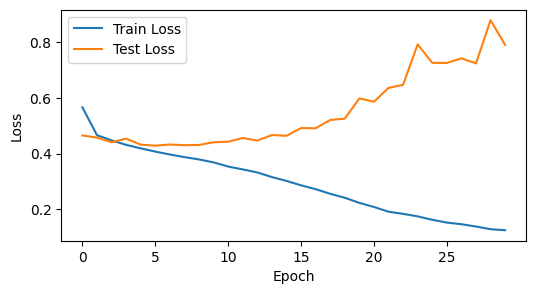

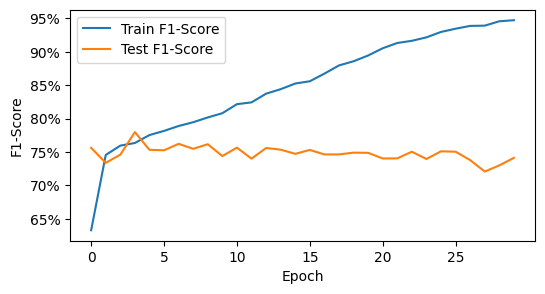

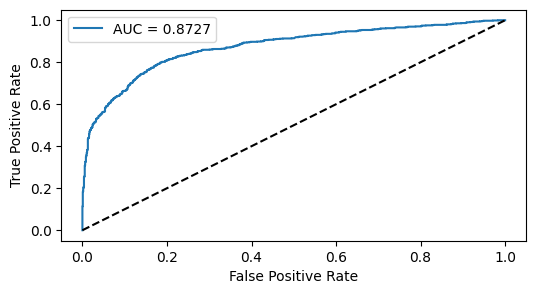

In [39]:
print('RNN - GRU')
plot_curves(results_gru["epochs"], results_gru["train_losses"], results_gru["valid_losses"], results_gru["train_f1s"], results_gru["valid_f1s"], results_gru["best_roc_data"])

In [40]:
results_gru_with_attention = []
results_gru_with_attention = run_model(model_gru_with_attention, optimizer_gru_with_attention, "gru_with_attention")

Epoch: 01
Train Loss: 0.5687 | F1 Score: 0.6856 | AUC-ROC: 0.7897 | Time: 1.10s
Valid Loss: 0.4826 | F1 Score: 0.7491 | AUC-ROC: 0.8480 | Time: 0.16s
Epoch: 02
Train Loss: 0.4759 | F1 Score: 0.7355 | AUC-ROC: 0.8471 | Time: 1.00s
Valid Loss: 0.4590 | F1 Score: 0.7439 | AUC-ROC: 0.8568 | Time: 0.16s
Epoch: 03
Train Loss: 0.4535 | F1 Score: 0.7486 | AUC-ROC: 0.8591 | Time: 1.19s
Valid Loss: 0.4668 | F1 Score: 0.7217 | AUC-ROC: 0.8541 | Time: 0.24s
Epoch: 04
Train Loss: 0.4423 | F1 Score: 0.7642 | AUC-ROC: 0.8668 | Time: 1.37s
Valid Loss: 0.4456 | F1 Score: 0.7534 | AUC-ROC: 0.8651 | Time: 0.16s
Epoch: 05
Train Loss: 0.4284 | F1 Score: 0.7678 | AUC-ROC: 0.8747 | Time: 1.03s
Valid Loss: 0.4413 | F1 Score: 0.7569 | AUC-ROC: 0.8680 | Time: 0.15s
Epoch: 06
Train Loss: 0.4139 | F1 Score: 0.7758 | AUC-ROC: 0.8830 | Time: 1.02s
Valid Loss: 0.4398 | F1 Score: 0.7596 | AUC-ROC: 0.8701 | Time: 0.16s
Epoch: 07
Train Loss: 0.4031 | F1 Score: 0.7882 | AUC-ROC: 0.8887 | Time: 1.01s
Valid Loss: 0.4409 |

RNN - GRU with Attention


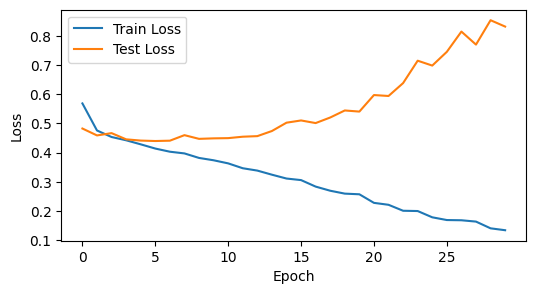

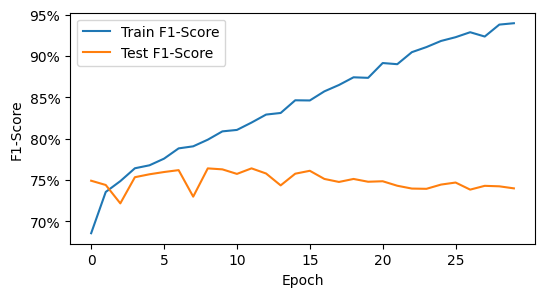

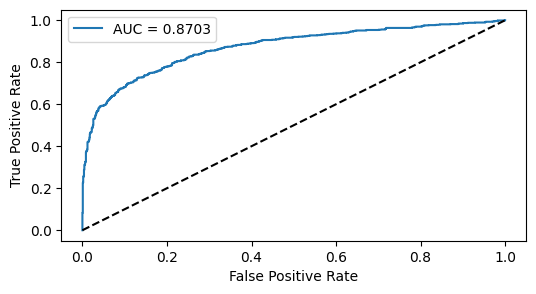

In [41]:
print('RNN - GRU with Attention')
plot_curves(results_gru_with_attention["epochs"], results_gru_with_attention["train_losses"], results_gru_with_attention["valid_losses"],
            results_gru_with_attention["train_f1s"], results_gru_with_attention["valid_f1s"], results_gru_with_attention["best_roc_data"])

## LSTM

In [42]:
model_lstm = RNN_LSTM(len(vocab), 100, 256, 2, vocab['<pad>']).to(device)
model_lstm_with_attention = RNN_LSTM_withAttention(len(vocab), 100, 256, 2, vocab['<pad>']).to(device)

criterion = nn.CrossEntropyLoss().to(device)

optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=1e-4, weight_decay=5e-5)
optimizer_lstm_with_attention = optim.Adam(model_lstm_with_attention.parameters(), lr=1e-4, weight_decay=5e-5)

print(model_lstm)
print("-----"*5)
print(model_lstm_with_attention)

RNN_LSTM(
  (embedding): Embedding(11092, 100, padding_idx=1)
  (rnn): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=512, out_features=2, bias=True)
)
-------------------------
RNN_LSTM_withAttention(
  (embedding): Embedding(11092, 100, padding_idx=1)
  (rnn): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (attn): Linear(in_features=512, out_features=1, bias=True)
  (fc): Linear(in_features=512, out_features=2, bias=True)
)


In [43]:
results_lstm = []
results_lstm = run_model(model_lstm, optimizer_lstm, "lstm")

Epoch: 01
Train Loss: 0.5992 | F1 Score: 0.5758 | AUC-ROC: 0.7940 | Time: 1.12s
Valid Loss: 0.4823 | F1 Score: 0.7332 | AUC-ROC: 0.8375 | Time: 0.17s
Epoch: 02
Train Loss: 0.4759 | F1 Score: 0.7397 | AUC-ROC: 0.8412 | Time: 1.01s
Valid Loss: 0.4600 | F1 Score: 0.7610 | AUC-ROC: 0.8612 | Time: 0.16s
Epoch: 03
Train Loss: 0.4559 | F1 Score: 0.7576 | AUC-ROC: 0.8560 | Time: 1.01s
Valid Loss: 0.4486 | F1 Score: 0.7398 | AUC-ROC: 0.8587 | Time: 0.16s
Epoch: 04
Train Loss: 0.4403 | F1 Score: 0.7559 | AUC-ROC: 0.8645 | Time: 1.03s
Valid Loss: 0.4487 | F1 Score: 0.7721 | AUC-ROC: 0.8688 | Time: 0.16s
Epoch: 05
Train Loss: 0.4262 | F1 Score: 0.7677 | AUC-ROC: 0.8736 | Time: 1.02s
Valid Loss: 0.4394 | F1 Score: 0.7609 | AUC-ROC: 0.8693 | Time: 0.16s
Epoch: 06
Train Loss: 0.4168 | F1 Score: 0.7740 | AUC-ROC: 0.8792 | Time: 1.01s
Valid Loss: 0.4368 | F1 Score: 0.7659 | AUC-ROC: 0.8700 | Time: 0.16s
Epoch: 07
Train Loss: 0.4092 | F1 Score: 0.7821 | AUC-ROC: 0.8850 | Time: 1.00s
Valid Loss: 0.4313 |

RNN - LSTM


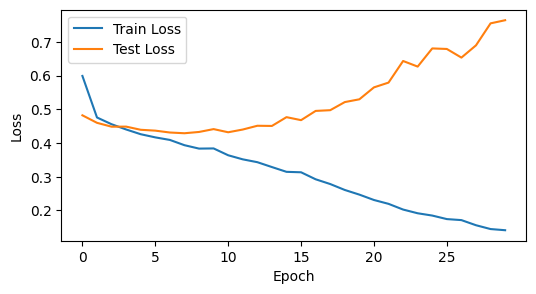

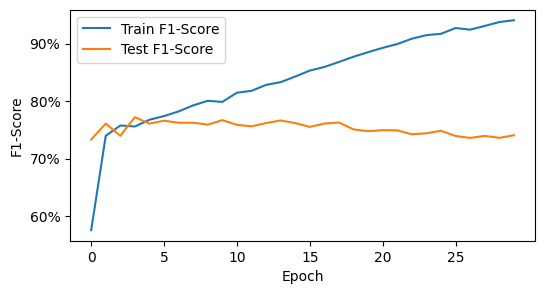

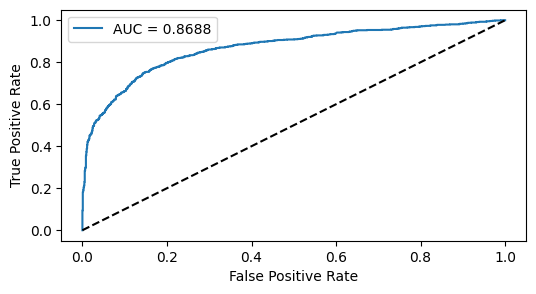

In [44]:
print('RNN - LSTM')
plot_curves(results_lstm["epochs"], results_lstm["train_losses"], results_lstm["valid_losses"], results_lstm["train_f1s"], results_lstm["valid_f1s"], results_lstm["best_roc_data"])

In [45]:
results_lstm_with_attention = []
results_lstm_with_attention = run_model(model_lstm_with_attention, optimizer_lstm_with_attention, "lstm_with_attention")

Epoch: 01
Train Loss: 0.6181 | F1 Score: 0.6294 | AUC-ROC: 0.7886 | Time: 1.14s
Valid Loss: 0.5095 | F1 Score: 0.7497 | AUC-ROC: 0.8291 | Time: 0.16s
Epoch: 02
Train Loss: 0.4984 | F1 Score: 0.7472 | AUC-ROC: 0.8305 | Time: 1.03s
Valid Loss: 0.4824 | F1 Score: 0.7506 | AUC-ROC: 0.8443 | Time: 0.17s
Epoch: 03
Train Loss: 0.4755 | F1 Score: 0.7566 | AUC-ROC: 0.8477 | Time: 1.04s
Valid Loss: 0.4643 | F1 Score: 0.7582 | AUC-ROC: 0.8555 | Time: 0.16s
Epoch: 04
Train Loss: 0.4502 | F1 Score: 0.7601 | AUC-ROC: 0.8599 | Time: 1.38s
Valid Loss: 0.4558 | F1 Score: 0.7424 | AUC-ROC: 0.8530 | Time: 0.26s
Epoch: 05
Train Loss: 0.4327 | F1 Score: 0.7679 | AUC-ROC: 0.8681 | Time: 1.15s
Valid Loss: 0.4458 | F1 Score: 0.7569 | AUC-ROC: 0.8644 | Time: 0.18s
Epoch: 06
Train Loss: 0.4183 | F1 Score: 0.7771 | AUC-ROC: 0.8778 | Time: 1.04s
Valid Loss: 0.4409 | F1 Score: 0.7547 | AUC-ROC: 0.8647 | Time: 0.16s
Epoch: 07
Train Loss: 0.4086 | F1 Score: 0.7822 | AUC-ROC: 0.8835 | Time: 1.03s
Valid Loss: 0.4448 |

RNN - LSTM with Attention


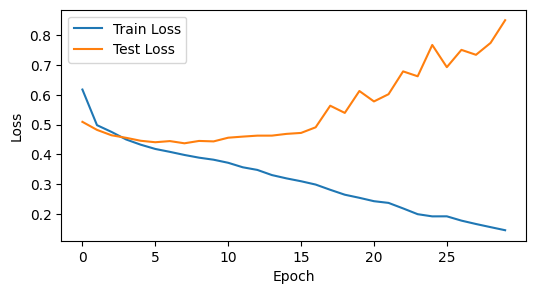

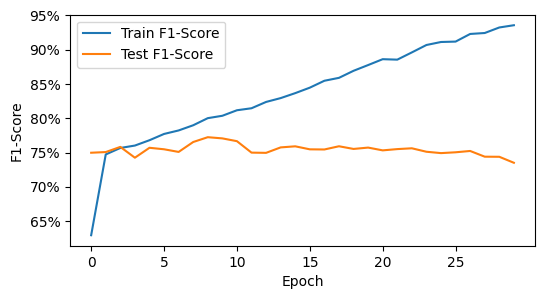

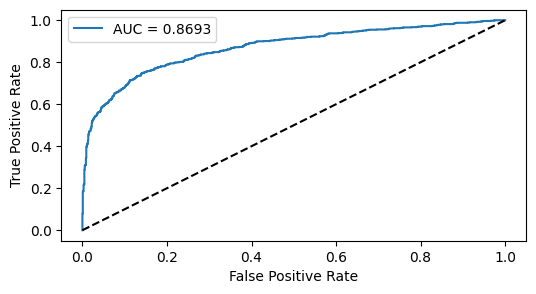

In [46]:
print('RNN - LSTM with Attention')
plot_curves(results_lstm_with_attention["epochs"], results_lstm_with_attention["train_losses"], results_lstm_with_attention["valid_losses"],
            results_lstm_with_attention["train_f1s"], results_lstm_with_attention["valid_f1s"], results_lstm_with_attention["best_roc_data"])

In [51]:
metrics_data_rnns = {
    'GRU': [results_gru["best_f1"], results_gru["best_auc"]],
    'GRU with Attention': [results_gru_with_attention["best_f1"], results_gru_with_attention["best_auc"]],
    'LSTM': [results_lstm["best_f1"], results_lstm["best_auc"]],
    'LSTM with Attention': [results_lstm_with_attention["best_f1"], results_lstm_with_attention["best_auc"]]
}

metrics_rnns_titles = ['Best F1-Score', 'Best ROC-AUC']
df_metrics_rnns = pd.DataFrame(metrics_data_rnns, index=metrics_rnns_titles)

In [52]:
df_metrics_rnns

,GRU,GRU with Attention,LSTM,LSTM with Attention
Best F1-Score,0.779800,0.764045,0.772144,0.772327
Best ROC-AUC,0.872743,0.870303,0.868771,0.869276


# Transformers (RoBERTa & DistilBERT)

In [53]:
from transformers import (
    RobertaTokenizer, RobertaModel,
    DistilBertTokenizer, DistilBertModel,
    AdamW, get_linear_schedule_with_warmup
)
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

/usr/local/lib/python3.11/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [54]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [55]:
class TransformerClassifier(nn.Module):
    def __init__(self, transformer_model, n_classes):
        super().__init__()
        self.transformer = transformer_model
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.transformer.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.transformer(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.last_hidden_state[:, 0, :]  # Use [CLS] token
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

In [56]:
def train_model(model, train_loader, val_loader, device, nn_type, num_epochs):
    optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss()

    # Calculate total training steps for scheduler
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    train_losses, valid_losses, train_f1s, valid_f1s = [], [], [], []
    best_val_f1 = 0.0
    best_roc_data = None

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch + 1}/{num_epochs}')

        # ---------------------
        # Training Phase
        # ---------------------
        start_train = time.time()
        model.train()
        total_train_loss = 0
        train_preds = []
        train_true = []

        for batch in tqdm(train_loader, desc='Training'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            total_train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            train_preds.extend(predicted.cpu().numpy())
            train_true.extend(labels.cpu().numpy())

        train_f1 = f1_score(train_true, train_preds)
        end_train = time.time()

        # ---------------------
        # Validation Phase
        # ---------------------
        start_eval = time.time()
        model.eval()
        total_val_loss = 0
        val_preds = []
        val_true = []
        val_probs = []  # For ROC curve

        with torch.no_grad():
            for batch in tqdm(val_loader, desc='Validation'):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)

                total_val_loss += loss.item()

                # Get predicted class
                _, predicted = torch.max(outputs.data, 1)
                val_preds.extend(predicted.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

                # Get probability for 1 class for ROC curve
                probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
                val_probs.extend(probs)

        val_f1 = f1_score(val_true, val_preds)

        # Calculate ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(val_true, val_probs)
        roc_auc = auc(fpr, tpr)
        valid_roc_data = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc, 'thresholds': thresholds}

        end_eval = time.time()

        # Store losses and f1 scores for later plotting
        train_losses.append(total_train_loss/len(train_loader))
        valid_losses.append(total_val_loss/len(val_loader))
        train_f1s.append(train_f1)
        valid_f1s.append(val_f1)

        # Compare valid_f1 with best_val_f1
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_roc_data = valid_roc_data
            # Save the model's state_dict
            torch.save(model.state_dict(), f"best_model_{nn_type}.pt")

        print(f"Train Loss: {total_train_loss/len(train_loader):.4f} | Train F1: {train_f1:.4f} | Time: {end_train-start_train:.2f}s")
        print(f"Valid Loss: {total_val_loss/len(val_loader):.4f} | Valid F1: {val_f1:.4f} | ROC AUC: {roc_auc:.4f} | Time: {end_eval-start_eval:.2f}s")

    print(f"\nThe best {nn_type.upper()} model had an F1-score of {best_val_f1:.4f}")

    metrics = {
        'epochs': num_epochs,
        'train_losses': train_losses,
        'valid_losses': valid_losses,
        'train_f1s': train_f1s,
        'valid_f1s': valid_f1s,
        'best_f1': best_val_f1,
        'best_roc_data': best_roc_data
    }

    return metrics

## RoBERTa

In [57]:
def setup_roberta(train_df, batch_size=16):
    # Initialize tokenizer and model
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    transformer = RobertaModel.from_pretrained('roberta-base')

    # Split data
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_df['treated_text'].values,
        train_df['target'].values,
        test_size=0.2,
        random_state=SEED
    )

    # Create datasets
    train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer)
    val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize model
    model = TransformerClassifier(transformer, n_classes=2)

    return model, train_loader, val_loader

In [58]:
def train_roberta(train_df):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Setup model and data
    model, train_loader, val_loader = setup_roberta(train_df)
    model = model.to(device)

    # Train the model
    return train_model(model, train_loader, val_loader, device, 'roberta', num_epochs=10)

In [59]:
results_roberta = []
results_roberta = train_roberta(treated_train_df)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/10


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.5092 | Train F1: 0.7184 | Time: 131.07s
Valid Loss: 0.4160 | Valid F1: 0.7854 | ROC AUC: 0.8868 | Time: 10.59s

Epoch 2/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.4018 | Train F1: 0.8030 | Time: 135.28s
Valid Loss: 0.3982 | Valid F1: 0.7885 | ROC AUC: 0.8906 | Time: 10.72s

Epoch 3/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.3503 | Train F1: 0.8349 | Time: 137.87s
Valid Loss: 0.4480 | Valid F1: 0.8109 | ROC AUC: 0.8876 | Time: 10.94s

Epoch 4/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.2886 | Train F1: 0.8658 | Time: 137.83s
Valid Loss: 0.5278 | Valid F1: 0.7899 | ROC AUC: 0.8786 | Time: 10.91s

Epoch 5/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.2433 | Train F1: 0.8960 | Time: 139.01s
Valid Loss: 0.5799 | Valid F1: 0.7862 | ROC AUC: 0.8709 | Time: 10.98s

Epoch 6/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.1978 | Train F1: 0.9231 | Time: 140.39s
Valid Loss: 0.8310 | Valid F1: 0.7818 | ROC AUC: 0.8724 | Time: 11.17s

Epoch 7/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.1706 | Train F1: 0.9365 | Time: 140.76s
Valid Loss: 0.8819 | Valid F1: 0.7808 | ROC AUC: 0.8553 | Time: 11.15s

Epoch 8/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.1533 | Train F1: 0.9458 | Time: 140.62s
Valid Loss: 1.0553 | Valid F1: 0.7794 | ROC AUC: 0.8608 | Time: 11.11s

Epoch 9/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.1428 | Train F1: 0.9519 | Time: 140.53s
Valid Loss: 1.1972 | Valid F1: 0.7783 | ROC AUC: 0.8623 | Time: 11.05s

Epoch 10/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.1238 | Train F1: 0.9587 | Time: 140.56s
Valid Loss: 1.1785 | Valid F1: 0.7774 | ROC AUC: 0.8609 | Time: 11.08s

The best ROBERTA model had an F1-score of 0.8109


Transformers - RoBERTa


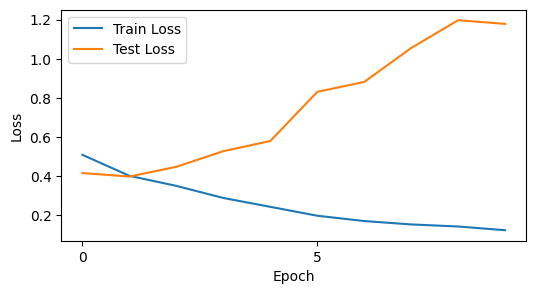

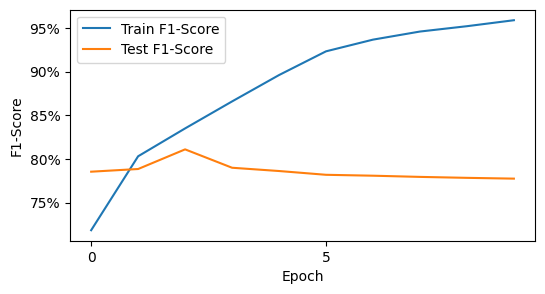

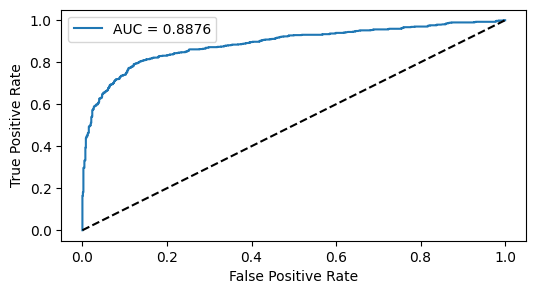

In [60]:
print('Transformers - RoBERTa')
plot_curves(results_roberta["epochs"], results_roberta["train_losses"], results_roberta["valid_losses"],
            results_roberta["train_f1s"], results_roberta["valid_f1s"], results_roberta["best_roc_data"])

## DistilBERT

In [61]:
def setup_distilbert(train_df, batch_size=16):
    # Initialize tokenizer and model
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    transformer = DistilBertModel.from_pretrained('distilbert-base-uncased')

    # Split data
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_df['treated_text'].values,
        train_df['target'].values,
        test_size=0.2,
        random_state=SEED
    )

    # Create datasets
    train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer)
    val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize model
    model = TransformerClassifier(transformer, n_classes=2)

    return model, train_loader, val_loader

In [62]:
def train_distilbert(train_df):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Setup model and data
    model, train_loader, val_loader = setup_distilbert(train_df)
    model = model.to(device)

    # Train the model
    return train_model(model, train_loader, val_loader, device, "distilbert", num_epochs=10)

In [63]:
results_distilbert = []
results_distilbert = train_distilbert(treated_train_df)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.4691 | Train F1: 0.7392 | Time: 68.09s
Valid Loss: 0.4096 | Valid F1: 0.8040 | ROC AUC: 0.8968 | Time: 5.86s

Epoch 2/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.3645 | Train F1: 0.8177 | Time: 69.18s
Valid Loss: 0.4072 | Valid F1: 0.7887 | ROC AUC: 0.8943 | Time: 5.94s

Epoch 3/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.2780 | Train F1: 0.8672 | Time: 69.74s
Valid Loss: 0.4724 | Valid F1: 0.7883 | ROC AUC: 0.8835 | Time: 6.04s

Epoch 4/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.2143 | Train F1: 0.9083 | Time: 70.05s
Valid Loss: 0.6037 | Valid F1: 0.7878 | ROC AUC: 0.8758 | Time: 6.16s

Epoch 5/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.1640 | Train F1: 0.9385 | Time: 70.36s
Valid Loss: 0.7760 | Valid F1: 0.7751 | ROC AUC: 0.8658 | Time: 6.09s

Epoch 6/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.1249 | Train F1: 0.9529 | Time: 70.64s
Valid Loss: 0.8522 | Valid F1: 0.7793 | ROC AUC: 0.8632 | Time: 6.18s

Epoch 7/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.1017 | Train F1: 0.9599 | Time: 70.52s
Valid Loss: 1.0608 | Valid F1: 0.7646 | ROC AUC: 0.8591 | Time: 6.20s

Epoch 8/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.0802 | Train F1: 0.9679 | Time: 71.10s
Valid Loss: 1.1267 | Valid F1: 0.7718 | ROC AUC: 0.8600 | Time: 6.15s

Epoch 9/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.0708 | Train F1: 0.9711 | Time: 70.87s
Valid Loss: 1.1780 | Valid F1: 0.7737 | ROC AUC: 0.8585 | Time: 6.25s

Epoch 10/10


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.0625 | Train F1: 0.9744 | Time: 71.23s
Valid Loss: 1.1888 | Valid F1: 0.7717 | ROC AUC: 0.8576 | Time: 6.21s

The best DISTILBERT model had an F1-score of 0.8040


Transformers - DistilBERT


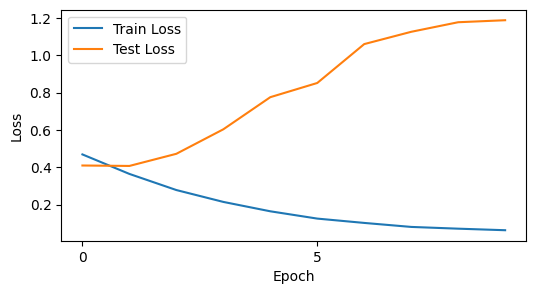

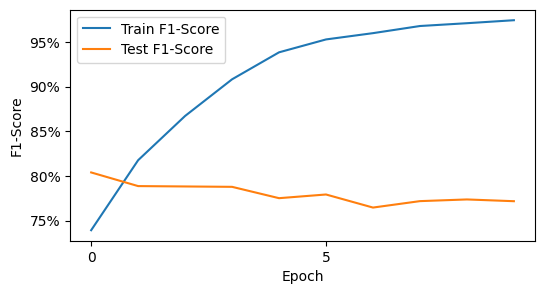

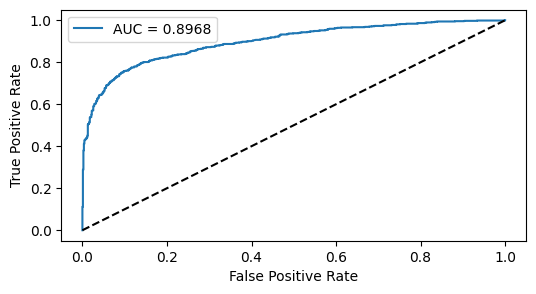

In [64]:
print('Transformers - DistilBERT')
plot_curves(results_distilbert["epochs"], results_distilbert["train_losses"], results_distilbert["valid_losses"],
            results_distilbert["train_f1s"], results_distilbert["valid_f1s"], results_distilbert["best_roc_data"])

In [70]:
metrics_data_transformers = {
    'RoBERTa': [results_roberta["best_f1"], results_roberta["best_roc_data"]["roc_auc"]],
    'DistilBERT': [results_distilbert["best_f1"], results_distilbert["best_roc_data"]["roc_auc"]]
}

metrics_transformers_titles = ['Best F1-Score', 'Best ROC-AUC']
df_metrics_transformers = pd.DataFrame(metrics_data_transformers, index=metrics_transformers_titles)

In [71]:
df_metrics_transformers

,RoBERTa,DistilBERT
Best F1-Score,0.810934,0.803951
Best ROC-AUC,0.887643,0.896761
